In [1]:
from scripts.mlogo import mlogo
import pandas as pd

> Initiating required folders: 
> folder `input` exists, continuing.
> folder `output` exists, continuing.
> folder `output//motif_figure` exists, continuing.
> folder `output//motif_data` exists, continuing.
> Loading parameters from `config.json` accessible as `config` variable. 


In [2]:
# Importing input file to pandas (can also read directly from file)
file_name = "input\\cl_seqs_all.csv"
seq_file = pd.read_csv(file_name, index_col=0)

# Chaning values in the columns which group the dataset
seq_file["ab_target"] = seq_file["ab_target"].map({"sp":"Spike Positive", "sn":"Spike Negative"})
seq_file["subject_id"] = seq_file["subject_id"].apply(lambda X : f"Subject {X[-1]}")


> Dataset loaded
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [1, 1], [1, 2], [1, 3], [1, 4]]
(0, 0)
(1, 0)
(2, 0)
(3, 0)
(4, 0)
(0, 1)
(1, 1)
(2, 1)
(3, 1)
(4, 1)
Plot saved as allseq_germline_5367logo at output folder
Raw motif dataframe information saveed into motif_data folder


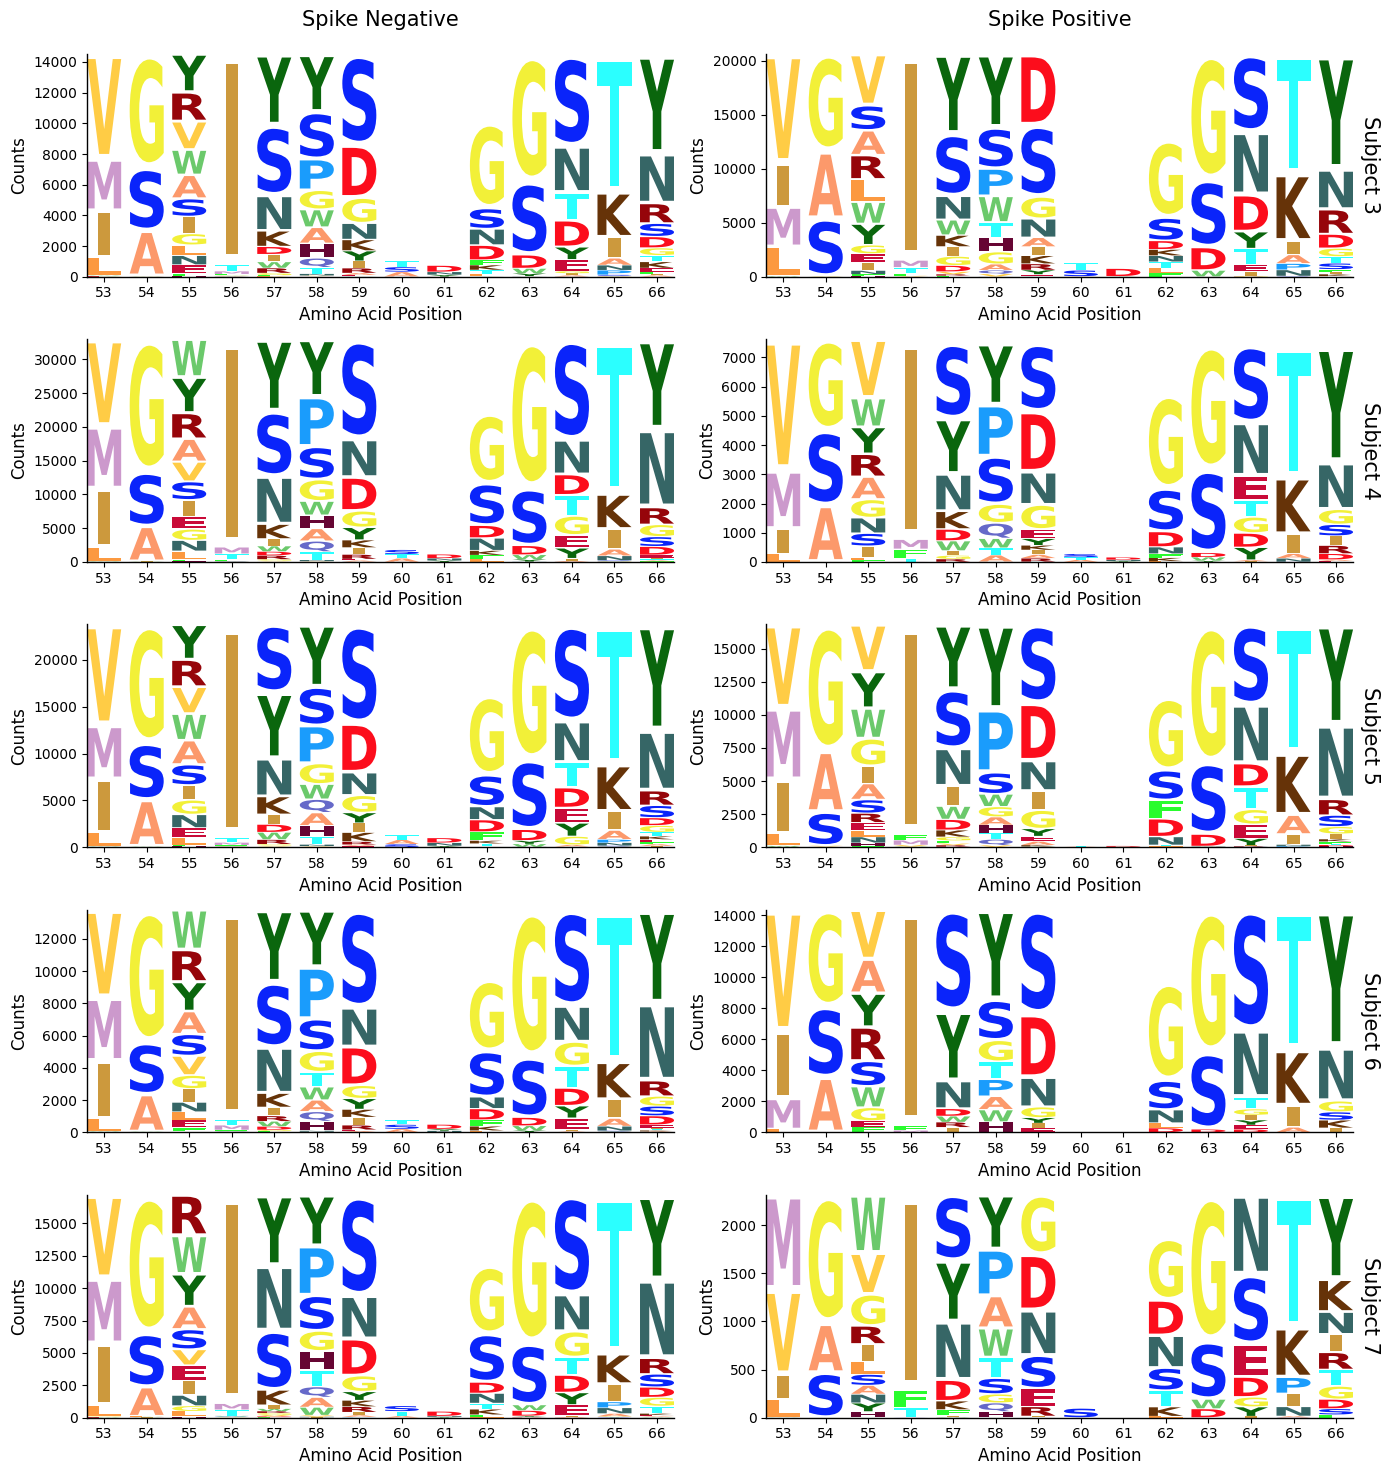

In [3]:
# Creating mlogo object (loading the data)
mlogo_obj= mlogo(seq_file, 
             group_by="ab_target",
             divide_subject=True)

# Creating motif plot of the wanted sequence, in this case:
# motif aa sequence (53-66): VAV ISYD..GSNK Y
seq_list = mlogo_obj.motif_logo(by="germline",
                                aa_start=52, 
                                aa_end=66,
                                yaxis_metric="counts",
                                save_name= "allseq_germline",
                                save_fig=True)